## Example 1 - creating structured and unstructured meshes

`Quagmire` can model surface processess on a structured rectangular grid or unstructured triangulated points. These use-cases are bundled into two objects:

- `PixMesh`: meshing on a rectangular grid
- `TriMesh`: meshing on unstructured triangular points
- `sTriMesh`: meshing on unstructured triangular points on the sphere

All meshes are generated and handed to Quagmire using a `DM` object where the selection of `PixMesh`, `TriMesh`, or `sTriMesh` is identified automatically by `QuagMesh`. The following data structures are built:

- Delaunay triangulation
- node neighbour array
- pointwise area and weights
- boundary information
- Rbf smoothing kernel

In this notebook we setup different `DM` objects using meshes found in the `quagmire.tools.meshtools` path and hand them to `QuagMesh`.


#### Contents

- [Structured grids](#Structured-grids)
- [Unstructued meshes](#Unstructured-meshes)
- [Elliptical mesh](#Elliptical-mesh)
- [Mesh improvement](#Mesh-improvement)
- [Mesh refinement](#Mesh-refinement)
- [Spherical meshes](#Spherical-meshes)
- [Save mesh to file](#Save-mesh-to-file)

In [1]:
from quagmire.tools import meshtools
from quagmire import QuagMesh
import numpy as np

ModuleNotFoundError: No module named 'quagmire'

## Structured grids

In [2]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0

resX = 75
resY = 75

DM = meshtools.create_DMDA(minX, maxX, minY, maxY, resX, resY)

print(type(DM))

NameError: name 'meshtools' is not defined

This is a native PETSc data management object for structured grids (`DMDA`). This object has a number of 
useful methods and attached data which can be listed with

```python
help(DM)
```

We hand this to `QuagMesh` to generate the necessary data structures for gradient operations, smoothing, neighbour allocation, etc.

In [3]:
mesh = QuagMesh(DM)

NameError: name 'QuagMesh' is not defined

We attach data to a mesh solely through mesh variables (see [Example notebook](Ex1a-QuagmireMeshVariables.ipynb) for details)

``` python
    mesh_variable = mesh.add_variable(name="data1")
    mesh_variable.data = np.sin(mesh.coords[:,0] * np.pi)
    mesh_variable.sync()
```

The `sync` operation ensures data is coherent across processors - 
it is harmless and relatively inexpensive so is safe to use even 
in cases like this where there is no way for information to be out
of sync between domains.

In [4]:
mesh_variable = mesh.add_variable(name="data1")
mesh_variable.data = np.sin(mesh.coords[:,0] * np.pi)
mesh_variable.sync()

mesh_variable2 = mesh.add_variable(name="data2")
mesh_variable2.data = np.sin(mesh.coords[:,0] * np.pi) * np.cos(mesh.coords[:,1] * np.pi) 
mesh_variable2.sync()

NameError: name 'mesh' is not defined

In [5]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[500,500], near=-10.0)

lvmesh = lv.quads(dims=(mesh.nx, mesh.ny), wireframe=True)
lvmesh.vertices(mesh.coords)
lvmesh.values( mesh_variable.data, "sinx")
lvmesh.colourmap("#FF0000, #555555 #0000FF", range=[-1.0,1.0])

# The mesh can be given a height mapping like this

vertices = np.zeros((mesh.coords.shape[0],3))
vertices[:,0:2] = mesh.coords
vertices[:,2]   = mesh_variable2.data * 0.5

lvmesh2 = lv.quads(dims=(mesh.nx, mesh.ny), wireframe=False)
lvmesh2.vertices(vertices)
lvmesh2.values(mesh_variable2.data,"sinxcosy")
lvmesh2.colourmap("#FF0000, #FFFFFF:0.5 #0000FF", range=[-1.0,1.0])


lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

NameError: name 'mesh' is not defined

## Unstructured meshes

This is handled by PETSc's `DMPlex` object, which requires the connectivity of a set of points. The connectivity between points can be triangulated using the built-in mesh creation tools:

```python
x, y, simplices = square_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
x, y, simplices = elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
```

and handed to `DMPlex` using:

```python
DM = meshtools.create_DMPlex(x, y, simplices, boundary_vertices=None, refinement_levels=0)
```

---

Alternatively, an arbitrary set of points (without duplicates) can be triangulated and processed as a `DMPlex` object using:

```python
meshtools.create_DMPlex_from_points(x, y, bmask=None, refinement_levels=0)
```

If no boundary information is provided, the boundary is assumed to be the convex hull of points.


#### Parallel notes

The triangulation from the root processor is distributed to other processors using the `DM` object, including boundary points and boundary edges. The mesh can be refined efficiently in parallel using the `refine_dm` method. The order of this operation is important:

1. Triangulate points
2. Mark boundary edges
3. Distribute `DMPlex` to other processors
4. Refine the mesh

## Elliptical mesh

In [6]:
spacingX = 0.1
spacingY = 0.1

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
DM = meshtools.create_DMPlex(x, y, simplices)

mesh = QuagMesh(DM)


mesh_equant = mesh.neighbour_cloud_distances.mean(axis=1) / ( np.sqrt(mesh.area))

NameError: name 'meshtools' is not defined

In [7]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

# lavavu also works in 3D - so need to stitch in a Z component  (zero or a height)

vertices = np.zeros((mesh.tri.points.shape[0],3))
vertices[:,0:2] = mesh.tri.points
# vertices[:,2] = heights

bnodes = lv.points("Boundary Points", pointsize=10.0, pointtype="shiny", colour="red", opacity=0.75)
bnodes.vertices(vertices[~mesh.bmask])

nodes = lv.points("All Points", pointsize=10.0, pointtype="shiny", colour="blue", opacity=0.75)
nodes.vertices(vertices)

simp = lv.triangles("Triangle Edges", wireframe=True, colour="#442222", opacity=0.75)
simp.vertices(vertices)
simp.indices(mesh.tri.simplices)

tris = lv.triangles("Triangle Areas",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(vertices-(0.0,0.0,0.01))
tris.indices(mesh.tri.simplices)
tris.values(mesh_equant, label="pointwise_area")

tris.colourmap("#000000, #FFFFFF")
cb = tris.colourbar()

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

lv.show()

NameError: name 'np' is not defined

## Mesh improvement

Applies Lloyd's algorithm of iterated voronoi construction to improve the mesh point locations. This distributes the points to a more uniform spacing with more equant triangles. It can be very slow for anything but a small mesh. [Refining](#Mesh-refinement) the mesh a few times will produce a large, well-spaced mesh.

In [8]:
bmask = mesh.bmask.copy()

x1, y1 = meshtools.lloyd_mesh_improvement(x, y, bmask, iterations=3)
DM = meshtools.create_DMPlex_from_points(x1, y1, bmask)

mesh1 = QuagMesh(DM)

NameError: name 'mesh' is not defined

In [9]:
mesh1_equant = mesh1.neighbour_cloud_distances.mean(axis=1) / ( np.sqrt(mesh1.area))

NameError: name 'mesh1' is not defined

In [10]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

# lavavu assumes 3D - so need to stitch in a Z component  (zero or a height)

vertices = np.zeros((mesh1.tri.points.shape[0],3))
vertices[:,0:2] = mesh1.tri.points

bnodes = lv.points("Boundary Points", pointsize=10.0, pointtype="shiny", colour="red", opacity=0.75)
bnodes.vertices(vertices[~mesh1.bmask])

simp = lv.triangles("Triangle Edges", wireframe=True, colour="#442222", opacity=0.75)
simp.vertices(vertices)
simp.indices(mesh1.tri.simplices)

tris = lv.triangles("Triangle Areas",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(vertices-(0.0,0.0,0.01))
tris.indices(mesh1.tri.simplices)
tris.values(mesh1_equant, label="pointwise_area")

tris.colourmap("#000000, #FFFFFF", range=[1.0,0.9*mesh1_equant.mean()])

cb = tris.colourbar()

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

lv.show()

NameError: name 'np' is not defined

NameError: name 'mesh_equant' is not defined

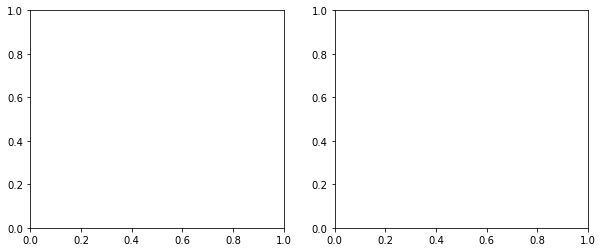

In [11]:
# Comparison of point-wise area for original and improved mesh


import matplotlib.pyplot as plt
%matplotlib inline


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.hist(mesh_equant, density=True)
ax2.hist(mesh1_equant, density=True)

ax1.set_title('original mesh')
ax2.set_title('improved mesh')

plt.show()

## Mesh refinement

Triangulating a large set of points on a single processor then distributing the mesh across multiple processors can be very slow. A more time effective workflow is to create an initial `DM` with a small number of points, then refine the mesh in parallel. This is achieved by adding the midpoint of each line segment to the mesh and can be iteratively refined until the desired level of detail is reached.

```python
refine_DM(dm, refinement_levels=1)
```

In [12]:
spacingX = 0.5
spacingY = 0.5

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
DM = meshtools.create_DMPlex(x, y, simplices)

DM_r1 = meshtools.refine_DM(DM, refinement_levels=1)
DM_r2 = meshtools.refine_DM(DM, refinement_levels=2)


# verbose=False turns off the timings

mesh0 = QuagMesh(DM, verbose=False)
mesh1 = QuagMesh(DM_r1, verbose=False)
mesh2 = QuagMesh(DM_r2, verbose=False)


v = DM_r1.getCoordinates()
v.array.shape

NameError: name 'meshtools' is not defined

In [13]:
def plot_points(lv, points, label, **kwargs):    
    lv_pts = lv.points(label, **kwargs)
    lv_pts.vertices(points)
    return lv_pts

def plot_triangles(lv, points, triangles, label, **kwargs):
    lv_tri = lv.triangles(label, **kwargs)
    lv_tri.vertices(points)
    lv_tri.indices(triangles)
    return lv_tri


lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

bnodes0 = plot_points(lv, mesh0.coords[~mesh0.bmask], "boundary_points_r0", colour="red", pointsize=10)
bnodes1 = plot_points(lv, mesh1.coords[~mesh1.bmask], "boundary_points_r1", colour="blue", pointsize=10)
bnodes2 = plot_points(lv, mesh2.coords[~mesh2.bmask], "boundary_points_r2", colour="#336611", pointsize=10)

tri0 = plot_triangles(lv, mesh0.coords, mesh0.tri.simplices, "mesh_r0", wireframe=True, linewidth=1.5, colour="red")
tri1 = plot_triangles(lv, mesh1.coords, mesh1.tri.simplices, "mesh_r1", wireframe=True, linewidth=1.0, colour="blue")
tri2 = plot_triangles(lv, mesh2.coords, mesh2.tri.simplices, "mesh_r2", wireframe=True, linewidth=1.0, colour="#336611")

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

lv.show()

NameError: name 'mesh0' is not defined

The DM contains two labels -- "coarse" and "boundary" -- which contain the vertices of boundary nodes and the unrefined mesh, respectively. They can be retrieved using:

```python
mesh.get_label("boundary")
mesh.get_label("coarse")
```

or a new label can be set using:

```python
mesh.set_label("my_label", indices)
```

In [14]:
coarse_pts0 = mesh0.get_label("coarse")
coarse_pts1 = mesh1.get_label("coarse")
coarse_pts2 = mesh2.get_label("coarse")

print("{} boundary points".format( len(mesh0.get_label("boundary")) ))
print("{} boundary points".format( len(mesh1.get_label("boundary")) ))
print("{} boundary points".format( len(mesh2.get_label("boundary")) ))


# the coarse point vertices should be identical
# refinement adds new points to the end of the x,y arrays

set(coarse_pts0) == set(coarse_pts1) == set(coarse_pts2)

NameError: name 'mesh0' is not defined

## Spherical meshes

This unstructed mesh uses PETSc's `DMPlex` object, and uses [stripy](https://github.com/underworldcode/stripy) to triangulate on the unit sphere. Multiple meshes may be created, including:

```python
DM = meshtools.create_spherical_DMPlex(lons, lats, simplices, boundary_vertices=None)
DM = meshtools.create_DMPlex_from_spherical_points(lons, lats, simplices, bmask=None, refinement_levels=0)
```

If no boundary information is provided, the boundary is calculated from any line segments that do not share a triangle with another.a

In [15]:
lons, lats, bmask = meshtools.generate_elliptical_points(-40, 40, -80, 80, 0.1, 0.1, 1500, 200)

DM = meshtools.create_DMPlex_from_spherical_points(lons, lats, bmask, refinement_levels=0)
DM_r1 = meshtools.create_DMPlex_from_spherical_points(lons, lats, bmask, refinement_levels=1)
DM_r2 = meshtools.create_DMPlex_from_spherical_points(lons, lats, bmask, refinement_levels=2)

mesh0 = QuagMesh(DM)
mesh1 = QuagMesh(DM_r1)
mesh2 = QuagMesh(DM_r2)

NameError: name 'meshtools' is not defined

In [16]:
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

bnodes0 = plot_points(lv, mesh0.data[~mesh0.bmask], "boundary_points_r0", colour="red", pointsize=10)
bnodes1 = plot_points(lv, mesh1.data[~mesh1.bmask], "boundary_points_r1", colour="blue", pointsize=10)
bnodes2 = plot_points(lv, mesh2.data[~mesh2.bmask], "boundary_points_r2", colour="#336611", pointsize=10)

tri0 = plot_triangles(lv, mesh0.data, mesh0.tri.simplices, "mesh_r0", wireframe=True, linewidth=1.5, colour="red")
tri1 = plot_triangles(lv, mesh1.data, mesh1.tri.simplices, "mesh_r1", wireframe=True, linewidth=1.0, colour="blue")
tri2 = plot_triangles(lv, mesh2.data, mesh2.tri.simplices, "mesh_r2", wireframe=True, linewidth=1.0, colour="#336611")

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

lv.show()

NameError: name 'mesh0' is not defined

## Save mesh to file

A mesh can be saved and imported later. The `QuagMesh` object has the `save_mesh_to_hdf5` method for this, as does `meshtools`.

**Note:** Requires PETSc 3.8 or higher

In [17]:
filename = "Ex1-refined_mesh.h5"

# save from QuagMesh object:
# mesh2.save_mesh_to_hdf5(filename)

# save from meshtools:
meshtools.save_DM_to_hdf5(DM_r2, filename)

# load DM from file
DM_r2 = meshtools.create_DMPlex_from_hdf5(filename)

mesh2 = QuagMesh(DM_r2)

NameError: name 'meshtools' is not defined

In [18]:
print(mesh2.npoints)
print(mesh2.area)

NameError: name 'mesh2' is not defined

The next example is [Ex2-Topography-Meshes](./Ex2-Topography-Meshes.ipynb)